In [4]:
from cycloneFilter import cycloneFilter
from solid import *
from solid.utils import *
import viewscad
import math
from copy import deepcopy

In [5]:
def crossSectionalArea(*params):
    '''
    calculate the cross sectional area of the given cycloneFilter.
    
    Parameters:
        cycloneFilterParams: parameters that will define a cycloneFilter
    Returns:
        rectangular area of intakeWidth*intakeHeight
    '''
    #POSITIONAL LEGEND:
    # initParams=[intakeSlitHeight=10, intakeSlitWidth=2,
    #     intakeLeft=True, vortexSearcherDepth=5, collectorDepth=75,
    #     cylinderRadius=10, cylinderHeight=15, wallWidth=0.05]
    
    #length times width is easiest calculation since inlet = outlet
    
    return params[0] * params[1]

In [6]:
def cycloneArray(init_params, delta_params, final_params, length, width, height, manifoldCeiling):
    '''
    build sequential/parallel array of cyclone filters in a cartesian grid pattern.
    starts by fitting width with init_params cycloneFilter objects, then alters geometry by delta_params 
    (currently can only functionally decrease parameters)and adds the equivalent airflow; 
    through each sequence of delta_params the total cross sectional area of filter intakes/outlets is kept constant. 
    (no bernoulli effect, all energy/pressure delta going to filtering friction/collision) 
    solution of the new cycloneFilter objects to the described rectangular prism.
    Stops when the rectangular prism is filled.
    
    Parameters:
            init_params: list of cycloneFilter positional parameters to start from
            delta_params: list of values that will change each respective positional init_params
            length: array size containing sequential filters
            width: array size containing parallel filters 
            height: array height for filters
            manifoldCeiling: height of manifold above cyclone filters
    '''
    #TODO: constrain manifoldCeiling to prevent pressure differential/bernoulli effect and integrate with height z axis constraints
    #TODO: add option or functional interface to take in vacuum_intake_manifold total cross sectional area and solve init_params intake_radius
    #       vacuum_intake_area = intake_radius*boxX_dimension/cylinder_radius #now solve for intake_radius..
    #                                                       ^ how many filters can fit in first row (reimman-sum sub-intervals of intake_radius)
    #
    #       intake_radius = vacuum_intake_area*cylinder_radius/boxX_dimension #solved for intake radius

    #TODO: assert each cyclone doesnt cause pressure differentials due to cylinder_radius
    #      being smaller than intake/outlet_radius (already preliminary cheked just need thorough code trace)
    #TODO: assert initial cylinder can fit in the first place (init cylinderRadius)
    #
    #TODO: curtains cause low pressure regions due to square loss across large volume. this increases clog chance greatly
    #      compared to high pressure pipelines minimized for cross section of intake/outlet where constant high velocity fields
    #      keep particle friction dynamic. This is too complicated, would require kernel stride from one sequence to the next.
    #      This would also require coarse grid such as in the initial sequence's intake since theres a venturi differential.
    #

    #TODO: set poisitional parameters as dictionary for keyword reference and unpack with ** operator
    #TODO: in the future attempt inheritance and polymorphism when creating heirarchy of parametrized abstraction (e.g.: cyclone filter->cyclone array)
    #POSITIONAL LEGEND:
    # initParams=[intakeSlitHeight=10, intakeSlitWidth=2,
    #     intakeLeft=True, vortexSearcherDepth=5, collectorDepth=75,
    #     cylinderRadius=10, cylinderHeight=15, wallWidth=0.05]
    
    #TODO: refactor/reduce all of this conditions are spread out too much
    ### CYCLONE VARIABLES ###
    params = init_params
    curPosition = [0,0]
    array = None
    xDistance, yDistance = 0, 0
    print(params)

    #deiterate cross-sectional area in this loop.
    arrayBuffer = [] #holds a cell of filters
    areaSolution = 0 #static total sum of cross sectional area needed in parallel 
                     #for sequence pressure equivalence (not considering pressure loss in filter)
    areaBuffer = 0 #buffer for deiterating areaSolution per row in a sequence
    
    while True: #sequential loop
        print('in the loop')
        
        ########### ITERATE TO NEXT SEQUENCE ###########
        if areaBuffer <= 0 and areaSolution != 0:
            print('\n iterating filter parameters-- new sequence.. \n')
            params = [y(x) if y(x) > z or z == -1 else x for x,y,z in zip(params, delta_params, final_params)]
            
            #set parameters based on given equation matrix, wallWidth is only float.
            paramsBuffer = [int(x) for x in params[:-1]]
            paramsBuffer.append(params[len(params)-1])
            params = paramsBuffer
            print(params)
            areaBuffer = areaSolution
            
            print('appending filters')
            #dump the buffer into the solution object
            for cyclone in arrayBuffer:
                if array is None:
                    array = cyclone
                else:
                    array+=cyclone
                    
            arrayBuffer.clear()
        
        #keep z dimension the same throughout array by mutating collector depth
        #TODO: this should be extracted and integrated into collectorDepth parameter 
        # of cycloneFilter parameterization
        #TODO: integrate this with manifold ceiling to reduce z-axis params
        if params[6] + params[4] < height:
            params[4] += height - (params[6] + params[4])
        elif params[6] + params[4] > height:
            params[4] -= (params[6] + params[4]) - height
        
        curPosition[1] += yDistance #y position
        curPosition[0] = 0 #carriage return x axis
        
        #distance between each filter
        xDistance = 2*params[5] + params[7] + 2*sqrt(params[1]*params[0]/pi)
        yDistance = 2.5*params[5] + params[7] 
        
        parallelFilters = math.ceil(width/xDistance)
        print('adding {} parallel filters to current sequence..'.format(parallelFilters))
        
        ########### INITIALIZE ###########
        if areaSolution == 0:
            #first filter sequence sets areaSolution (currently just one row is initial cell)
            areaSolution = parallelFilters*crossSectionalArea(*params)
            areaBuffer = areaSolution
            print('initialized areaSolution: {} areaBuffer: {}'.format(areaSolution, areaBuffer))
            
        if curPosition[1] > length:
            print('EOL: filter sequence')
            #TODO: remove manifolds in dump log
            print('dumping {} buffer items from last sequence clipping'.format(len(arrayBuffer))) 
            arrayBuffer.clear()
            break
                    
        ########### ADD FILTERS TO CURRENT SEQUENCE###########
        #TODO: some of this can likely be refactored out to function calls
        print('parallelFilters {} mod 2 is {}'.format(parallelFilters, parallelFilters%2))
        
        intakeRadius = sqrt(params[0]*params[1]/pi)
        
        if parallelFilters%2 != 0:
            if areaBuffer <= 0:
                #reached parallel cross-sectional area equivalence
                break
                
            print('odd')
            #start from origin then offset each filter origin+xDistance
            initialFilter = cycloneFilter(*params)
            initialFilter = left(curPosition[0])(initialFilter) #TODO: this always follows xDistance carriage return
            initialFilter = forward(curPosition[1])(initialFilter)

            #have to tap manifold access lines, since hole() cant be used due to vortex searcher
            manifoldAccess = cylinder(r=intakeRadius - params[7], h=2*params[7])
            manifoldAccess = left(curPosition[0])(manifoldAccess)
            manifoldAccess = forward(curPosition[1])(manifoldAccess)

            initialFilter = initialFilter - hole()(manifoldAccess)

            curPosition[0] += xDistance
            
            arrayBuffer.append(initialFilter)
            areaBuffer -= crossSectionalArea(*params)
            print('areaBuffer: {}'.format(areaBuffer))
            
            #parallel loop parallel_filters is int so /2 is okay
            #TODO: this is likely overstepping the area? double check this
            for x in range(int((parallelFilters-1)//2)): 
                print('areaBuffer: {}'.format(areaBuffer))
                if areaBuffer <= 0:
                    #reached parallel cross-sectional area equivalence
                    break
                
                leftParams = params
                leftParams[2] = True
                #tap manifold from cylinder
                #TODO: tap origin filter in odd iteration
                leftManifoldAccess = cylinder(r=intakeRadius - params[7], h=2*params[7])
                leftManifoldAccess = left(curPosition[0])()(leftManifoldAccess)
                leftManifoldAccess = forward(curPosition[1])()(leftManifoldAccess)

                leftFilter = cycloneFilter(*leftParams)
                leftFilter = left(curPosition[0])(leftFilter)
                leftFilter = forward(curPosition[1])(leftFilter)
                
                leftFilter = leftFilter - hole()(leftManifoldAccess)

                rightParams = params
                rightParams[2] = False
                #tap manifold from cylinder
                rightManifoldAccess = cylinder(r=intakeRadius - params[7], h=2*params[7])
                rightManifoldAccess = right(curPosition[0])()(rightManifoldAccess)
                rightManifoldAccess = forward(curPosition[1])()(rightManifoldAccess)

                rightFilter = cycloneFilter(*rightParams)
                rightFilter = right(curPosition[0])(rightFilter)
                rightFilter = forward(curPosition[1])(rightFilter)

                rightFilter = rightFilter - hole()(rightManifoldAccess)

                curPosition[0] += xDistance
                
                arrayBuffer.append(leftFilter)
                areaBuffer -= crossSectionalArea(*params)
                arrayBuffer.append(rightFilter)
                areaBuffer -= crossSectionalArea(*params)

            ########### MANIFOLD ###########
            #TODO: refactor and extract duplicate cases
            #TODO: verify cylinderRadius
             #spans entire row, height and width set to volume constraint
            intakePosition = params[5] - intakeRadius
            manifoldSpan = 2*(curPosition[0] - xDistance + intakeRadius)

            # build the manifold exhaust extrusion
            manifoldExhaustSolid = cube([width/2 + params[7], params[5] + params[7], manifoldCeiling + params[7]])
            # add curvature for z axis differentiability and therefor 3d printability
            exhaustHood = cube([width/2, params[5]/2, manifoldCeiling]) #makes object differentiable therefor 3d printable

            manifoldExhaustSolid = hull()(manifoldExhaustSolid + up(manifoldCeiling+params[7])(exhaustHood)) 

            manifoldExhaust = right(params[7]/2)(up(params[7]/2)(forward(params[7])(cube([width/2, params[5], manifoldCeiling]))))
            manifoldExhaust = manifoldExhaustSolid - hole()(manifoldExhaust)

            manifoldExhaust = right(manifoldSpan/2 + params[7] - width/4)(manifoldExhaust)
            manifoldExhaust = forward(params[5]/2)(manifoldExhaust)

            #now build the actual manifold connecting the row of cyclones
            intakeManifoldSolid = cube([manifoldSpan+params[7], 2*intakeRadius + params[7], manifoldCeiling + params[7]])
            manifoldHood = cube([manifoldSpan, intakeRadius, manifoldCeiling])

            intakeManifoldSolid = hull()(intakeManifoldSolid + up(manifoldCeiling+params[7])(manifoldHood))

            intakeManifold = up(params[7]/2)(right(params[7]/2)(hull()(cube([manifoldSpan, 2*intakeRadius, manifoldCeiling]))))
            intakeManifold = intakeManifoldSolid - hole()(forward(params[7]/2)(intakeManifold))

            intakeManifold = intakeManifold + manifoldExhaust
            #position atop the array
            intakeManifold = forward(curPosition[1]-intakeRadius)(intakeManifold)
            intakeManifold = left(manifoldSpan/2)(intakeManifold)
            intakeManifold = up(params[7])(intakeManifold)
            
            arrayBuffer.append(intakeManifold)
            #TODO: now go up and over
            ########### END OF MANIFOLD ###########

        else:
            print('even')
            #start from origin + xDistance/2
            curPosition[0] += xDistance/2
            for x in range(int(parallelFilters//2)): #parallel loop
                print('areaBuffer: {}'.format(areaBuffer))
                if areaBuffer <= 0:
                    #reached parallel cross-sectional area equivalence
                    break
                
                leftParams = params
                leftParams[2] = True
                #tap manifold from cylinder
                leftManifoldAccess = cylinder(r=intakeRadius - params[7], h=2*params[7])
                leftManifoldAccess = left(curPosition[0])()(leftManifoldAccess)
                leftManifoldAccess = forward(curPosition[1])()(leftManifoldAccess)

                leftFilter = cycloneFilter(*leftParams)
                leftFilter = left(curPosition[0])(leftFilter)
                leftFilter = forward(curPosition[1])(leftFilter)

                leftFilter = leftFilter - hole()(leftManifoldAccess)

                rightParams = params
                rightParams[2] = False
                #tap manifold from cylinder
                rightManifoldAccess = cylinder(r=intakeRadius - params[7], h=2*params[7])
                rightManifoldAccess = right(curPosition[0])()(rightManifoldAccess)
                rightManifoldAccess = forward(curPosition[1])()(rightManifoldAccess)

                rightFilter = cycloneFilter(*rightParams)
                rightFilter = right(curPosition[0])(rightFilter)
                rightFilter = forward(curPosition[1])(rightFilter)

                rightFilter = rightFilter - hole()(rightManifoldAccess)


                curPosition[0] += xDistance
                
                arrayBuffer.append(leftFilter)
                areaBuffer -= crossSectionalArea(*params)
                arrayBuffer.append(rightFilter)
                areaBuffer -= crossSectionalArea(*params)
            
            ########### MANIFOLD ###########
            #TODO: refactor and extract duplicate cases
            #TODO: verify cylinderRadius
             #spans entire row, height and width set to volume constraint
            intakePosition = params[5] - intakeRadius
            manifoldSpan = 2*(curPosition[0] - xDistance + intakeRadius)

            # build the manifold exhaust extrusion
            manifoldExhaustSolid = cube([width/2 + params[7], params[5] + params[7], manifoldCeiling + params[7]])
            # add curvature for z axis differentiability and therefor 3d printability
            exhaustHood = cube([width/2, params[5]/2, manifoldCeiling]) #makes object differentiable therefor 3d printable

            manifoldExhaustSolid = hull()(manifoldExhaustSolid + up(manifoldCeiling+params[7])(exhaustHood)) 

            manifoldExhaust = right(params[7]/2)(up(params[7]/2)(forward(params[7])(cube([width/2, params[5], manifoldCeiling]))))
            manifoldExhaust = manifoldExhaustSolid - hole()(manifoldExhaust)

            manifoldExhaust = right(manifoldSpan/2 + params[7] - width/4)(manifoldExhaust)
            manifoldExhaust = forward(params[5]/2)(manifoldExhaust)

            #now build the actual manifold connecting the row of cyclones
            intakeManifoldSolid = cube([manifoldSpan+params[7], 2*intakeRadius + params[7], manifoldCeiling + params[7]])
            manifoldHood = cube([manifoldSpan, intakeRadius, manifoldCeiling])

            intakeManifoldSolid = hull()(intakeManifoldSolid + up(manifoldCeiling+params[7])(manifoldHood))

            intakeManifold = up(params[7]/2)(right(params[7]/2)(hull()(cube([manifoldSpan, 2*intakeRadius, manifoldCeiling]))))
            intakeManifold = intakeManifoldSolid - hole()(forward(params[7]/2)(intakeManifold))

            intakeManifold = intakeManifold + manifoldExhaust
            #position atop the array
            intakeManifold = forward(curPosition[1]-intakeRadius)(intakeManifold)
            intakeManifold = left(manifoldSpan/2)(intakeManifold)
            intakeManifold = up(params[7])(intakeManifold)
            
            arrayBuffer.append(intakeManifold)
            #TODO: now go up and over
            ########### END OF MANIFOLD ###########

    return array

[50000, 15000, True, 10000, 30000, 50000, 100000, 100]
in the loop
adding 2 parallel filters to current sequence..
initialized areaSolution: 1500000000 areaBuffer: 1500000000
parallelFilters 2 mod 2 is 0
even
areaBuffer: 1500000000
in the loop

 iterating filter parameters-- new sequence.. 

[25000, 7500, 0, 10000, 100000, 25000, 100000, 100]
appending filters
adding 4 parallel filters to current sequence..
parallelFilters 4 mod 2 is 0
even
areaBuffer: 1500000000
areaBuffer: 1125000000
in the loop
adding 4 parallel filters to current sequence..
parallelFilters 4 mod 2 is 0
even
areaBuffer: 750000000
areaBuffer: 375000000
in the loop

 iterating filter parameters-- new sequence.. 

[12500, 3750, 0, 10000, 100000, 12500, 100000, 100]
appending filters
adding 7 parallel filters to current sequence..
EOL: filter sequence
dumping 0 buffer items from last sequence clipping
done <solid.objects.union object at 0x000001E3D8E0A040>


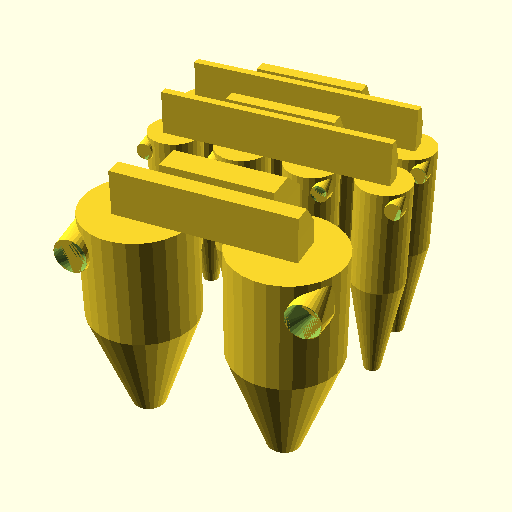

In [7]:
#TODO: fix openscad-freecad plugin
#      create qt widget menu for entering [:3] params then drafting cube constraint [4:] params
#      make mod plugins for freecad, start with different fill primitives e.g.: cylinder, possible sphere and eventually any convex polygons in R3 

#POSITIONAL LEGEND:
# initParams=[intakeSlitHeight=10, intakeSlitWidth=2,
#     intakeLeft=True, vortexSearcherDepth=5, collectorDepth=75,
#     cylinderRadius=10, cylinderHeight=15, wallWidth=0.05]

#reduction methods
geometric_reduction_slit_height = lambda x: x/2 #remove floor bound
geometric_reduction_slit_width = lambda x: x/2 #remove floor bound
geometric_reduction_radius = lambda x: x/2 #remove floor bound
geometric_increase_height = lambda x: x + x/4 #remove ceiling bound
#null is special case for no-op
null = lambda x: x

init_params=[50000, 15000, 
            True, 10000, 30000,
            50000, 100000, 100]

delta_params=[geometric_reduction_slit_width, geometric_reduction_slit_height,
              null, null, null,
              geometric_reduction_radius, null, null]

#-1 is special case for unbounded
final_params=[500, 1000,
            -1, -1, -1,
            pi*1000, 20000, -1]

# cycloneArray = cycloneArray(init_params, delta_params, final_params, 500000, 500000, 500000, 20000)
cycloneArray = cycloneArray(init_params, delta_params, final_params, 200000, 200000, 200000, 20000)

print('done', cycloneArray)
cycloneArray

In [8]:
############# Writeout Filter Model #############
scad_render_to_file(
    cycloneArray,
    "cycloneArray.scad",
)

'C:/Users/wardj/Desktop/code/parametric_models/solidutils/cycloneArray.scad'

In [9]:
#center point of intake:
#center point of outlet:

### MANIFOLD PIPELINE AND INTERFACES
- intake needs a grid for coarse grain filtering with squares of the smallest dimension (intakeSlitWidth) and exhaust needs cone with exponential slope (horn) to match radial compressor (these will be interface geometries to this module and should be designed seperately).
- also can have no manifold and seal off each row, exposing only the outlet of previous layer and inlet of next. highest clog chance Also works with creating a box around the cyclone array. can also remove most of the intake nozzle, essentially leaving a rectangular slit as the inlet for ease of manufacturing (no internal masting).

- set a manfold receptacle for intake and outlet respectively, extruded rectangular prism of width, height=intake_diameter. connect each with simple vertical+horizontal ventillation attached at 90 degrees that connects each receptacle per sequence. consider an extremely elongated elipse linearly extruded (rectangle with both smaller sides curved) to reduce swirl against sharp edges (edges of rectanglular prism w.r.t. inlets)

- empirically verify cyclone clogging. Clearview cyclone clogs due to very large pressure differential to inner cyclone intake, limiting larger particles which have a chance to disrupt small particle agglomeration. need collision oriented filtration/energy loss to avoid aglomeration and therefore latent clogging in the sequence.
- E.G.: beads of glass or large sand traveling through, striking dust agglomerates can act as a rudimentary cleaning method if flow fields are even throughout the manifold (large volumes can cause beads to lose energy before traveling the same path as dust particulates, falling out of primary streamline and reducing clog striking chance). This trades geometry problems with material problems from sheer loss and isnt desirable except in the integrated case of particulate collision in cyclone.

### CONSTRAINTS 
- increase  parallel splits based on intake **cross sectional area** to keep total cross sectional area across all filters the same per sequence
- this requires manifold pipeline to allow residual 'skip' connections to the next row, in cases where a single row of the new delta_param iterated geometry doesnt fulfill cross sectional inlet/outlet equivalence. This is critical for optimal pressure differential (energy going into filtering not venturi loss).
- arrayConstraints for parametric interface: rect. prism [x,y,z]

### TODOS 
- GITHUB: set project sub-directory for cyclone filtration modules. label a README to make this discoverable through google crawlers.
- consider a hair filter or long slender blob filter as these are the worst case for this geometry of cyclone filter. should be okay with a low pressure, high volume intake zone before the cycloneArray (see drawing).
- FIXED (VERIFY) is it okay to have negative areaBuffer in a sequence? may cause pressure to drop in this sequence, reducing airflow and therefore angular velocity therefore centripetal acceleration of particulates.
- consider initial cyclone with no collector cone as vortex isnt as necessary with very large mass blobs. need to consider how this will perturb the collection bin wrt future sequence filter collector backfeeding.

### FUTURE DEVELOPMENT
- create a radial array arrangement as well, attempt to reuse fitting optimization code from cycloneArray() for abstract geometries. Largest limiting factor here is manifold pathplanning (dont avoid this feature, this is half the reason we are using python).
